# CS6340 Project 2: Predict Real Estate Sale Prices

## By Jack Schlederer

TODO

In [154]:
import pandas as pd
import seaborn as sns
import numpy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [155]:
# housing_df = pd.read_csv('/content/drive/MyDrive/cs6340_lab2/Sacramentorealestatetransactions.csv')
housing_df = pd.read_csv('D:\Development\ml_project_2\Sacramentorealestatetransactions.csv')
housing_df.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [156]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   street     985 non-null    object 
 1   city       985 non-null    object 
 2   zip        985 non-null    int64  
 3   state      985 non-null    object 
 4   beds       985 non-null    int64  
 5   baths      985 non-null    int64  
 6   sq__ft     985 non-null    int64  
 7   type       985 non-null    object 
 8   sale_date  985 non-null    object 
 9   price      985 non-null    int64  
 10  latitude   985 non-null    float64
 11  longitude  985 non-null    float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.5+ KB


In [157]:
housing_df['city'] = housing_df['city'].astype('category')
housing_df['zip'] = housing_df['zip'].astype('category')
housing_df['state'] = housing_df['state'].astype('category')
housing_df['type'] = housing_df['type'].astype('category')
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   street     985 non-null    object  
 1   city       985 non-null    category
 2   zip        985 non-null    category
 3   state      985 non-null    category
 4   beds       985 non-null    int64   
 5   baths      985 non-null    int64   
 6   sq__ft     985 non-null    int64   
 7   type       985 non-null    category
 8   sale_date  985 non-null    object  
 9   price      985 non-null    int64   
 10  latitude   985 non-null    float64 
 11  longitude  985 non-null    float64 
dtypes: category(4), float64(2), int64(4), object(2)
memory usage: 69.8+ KB


In [158]:
one_hot_df_list = list()

for column in ['city', 'zip', 'type']:
  _oh_encoded = pd.get_dummies(housing_df[column], prefix=column)
  one_hot_df_list.append(_oh_encoded)

experiment_dataframe = pd.concat(one_hot_df_list, axis=1)
housing_df = pd.concat([housing_df, experiment_dataframe], axis=1)
housing_df.drop(['city', 'zip', 'state', 'type'], axis='columns')

,street,beds,baths,sq__ft,sale_date,price,latitude,longitude,city_ANTELOPE,city_AUBURN,city_CAMERON PARK,city_CARMICHAEL,city_CITRUS HEIGHTS,city_COOL,city_DIAMOND SPRINGS,city_EL DORADO,city_EL DORADO HILLS,city_ELK GROVE,city_ELVERTA,city_FAIR OAKS,city_FOLSOM,city_FORESTHILL,city_GALT,city_GARDEN VALLEY,city_GOLD RIVER,city_GRANITE BAY,city_GREENWOOD,city_LINCOLN,city_LOOMIS,city_MATHER,city_MEADOW VISTA,city_NORTH HIGHLANDS,city_ORANGEVALE,city_PENRYN,city_PLACERVILLE,city_POLLOCK PINES,city_RANCHO CORDOVA,city_RANCHO MURIETA,city_RIO LINDA,city_ROCKLIN,city_ROSEVILLE,city_SACRAMENTO,city_SHINGLE SPRINGS,city_SLOUGHHOUSE,city_WALNUT GROVE,city_WEST SACRAMENTO,city_WILTON,zip_95603,zip_95608,zip_95610,zip_95614,zip_95619,zip_95621,zip_95623,zip_95624,zip_95626,zip_95628,zip_95630,zip_95631,zip_95632,zip_95633,zip_95635,zip_95648,zip_95650,zip_95655,zip_95660,zip_95661,zip_95662,zip_95663,zip_95667,zip_95670,zip_95673,zip_95677,zip_95678,zip_95682,zip_95683,zip_95690,zip_95691,zip_95693,zip_95722,zip_95726,zip_95742,zip_95746,zip_95747,zip_95757,zip_95758,zip_95762,zip_95765,zip_95811,zip_95814,zip_95815,zip_95816,zip_95817,zip_95818,zip_95819,zip_95820,zip_95821,zip_95822,zip_95823,zip_95824,zip_95825,zip_95826,zip_95827,zip_95828,zip_95829,zip_95831,zip_95832,zip_95833,zip_95834,zip_95835,zip_95838,zip_95841,zip_95842,zip_95843,zip_95864,type_Condo,type_Multi-Family,type_Residential,type_Unkown
0,3526 HIGH ST,2,1,836,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,51 OMAHA CT,3,1,1167,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2796 BRANCH ST,2,1,796,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2805 JANETTE WAY,2,1,852,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,6001 MCMAHON DR,2,1,797,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,9169 GARLINGTON CT,4,3,2280,Thu May 15 00:00:00 EDT 2008,232425,38.457679,-121.359620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
981,6932 RUSKUT WAY,3,2,1477,Thu May 15 00:00:00 EDT 2008,234000,38.499893,-121.458890,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

<AxesSubplot:xlabel='price', ylabel='Count'>

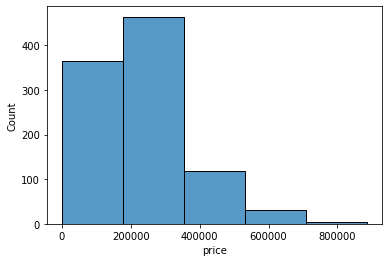

In [159]:
bin_count = 5

bins = numpy.histogram_bin_edges(housing_df['price'], bins=bin_count)
sns.histplot(housing_df['price'], bins=bins)

In [160]:
bin_array = numpy.digitize(housing_df['price'], bins)
housing_df['price_bin'] = pd.Series(bin_array)
housing_df

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,city_ANTELOPE,city_AUBURN,city_CAMERON PARK,city_CARMICHAEL,city_CITRUS HEIGHTS,city_COOL,city_DIAMOND SPRINGS,city_EL DORADO,city_EL DORADO HILLS,city_ELK GROVE,city_ELVERTA,city_FAIR OAKS,city_FOLSOM,city_FORESTHILL,city_GALT,city_GARDEN VALLEY,city_GOLD RIVER,city_GRANITE BAY,city_GREENWOOD,city_LINCOLN,city_LOOMIS,city_MATHER,city_MEADOW VISTA,city_NORTH HIGHLANDS,city_ORANGEVALE,city_PENRYN,city_PLACERVILLE,city_POLLOCK PINES,city_RANCHO CORDOVA,city_RANCHO MURIETA,city_RIO LINDA,city_ROCKLIN,city_ROSEVILLE,city_SACRAMENTO,city_SHINGLE SPRINGS,city_SLOUGHHOUSE,city_WALNUT GROVE,city_WEST SACRAMENTO,city_WILTON,zip_95603,zip_95608,zip_95610,zip_95614,zip_95619,zip_95621,zip_95623,zip_95624,zip_95626,zip_95628,zip_95630,zip_95631,zip_95632,zip_95633,zip_95635,zip_95648,zip_95650,zip_95655,zip_95660,zip_95661,zip_95662,zip_95663,zip_95667,zip_95670,zip_95673,zip_95677,zip_95678,zip_95682,zip_95683,zip_95690,zip_95691,zip_95693,zip_95722,zip_95726,zip_95742,zip_95746,zip_95747,zip_95757,zip_95758,zip_95762,zip_95765,zip_95811,zip_95814,zip_95815,zip_95816,zip_95817,zip_95818,zip_95819,zip_95820,zip_95821,zip_95822,zip_95823,zip_95824,zip_95825,zip_95826,zip_95827,zip_95828,zip_95829,zip_95831,zip_95832,zip_95833,zip_95834,zip_95835,zip_95838,zip_95841,zip_95842,zip_95843,zip_95864,type_Condo,type_Multi-Family,type_Residential,type_Unkown,price_bin
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,9169 GARLINGTON CT,SACRAMENTO,95829,CA,4,3,2280,Residential,Thu May 15 00:00:00 EDT 2008,232425,38.457679,-121.359620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2
981,6932 RUSK

In [161]:
housing_df['price_bin'] = housing_df['price_bin'].where(housing_df['price_bin'] != (bin_count + 1), other=bin_count)
training_df, testing_df = train_test_split(housing_df, test_size=0.25, train_size=0.75, stratify=housing_df['price_bin'])

In [162]:
training_df.shape

(738, 124)

In [163]:
testing_df.shape

(247, 124)

In [164]:
numeric_columns = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude']
scaled_columns = ['beds_scaled', 'baths_scaled', 'sq__ft_scaled', 'latitude_scaled', 'longitude_scaled']

numeric_pipeline = make_pipeline(StandardScaler())

full_pipeline = ColumnTransformer([
    ("numeric", numeric_pipeline, numeric_columns)
])

# We could make a pipeline here with a one-hot encoder for the categorical columns but that's already been done

# Fit and apply the StandardScaler with the training data, then apply it to the testing data
training_df[scaled_columns] = full_pipeline.fit_transform(training_df)
testing_df[scaled_columns] = full_pipeline.transform(testing_df)

# Get the price columns
training_prices = training_df['price']
testing_prices = testing_df['price']

# Drop the columns we don't want to use in the regression model
columns_to_drop = ['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type', 'sale_date', 'price', 'latitude', 'longitude', 'price_bin']
training_df = training_df.drop(columns=columns_to_drop)
testing_df = testing_df.drop(columns=columns_to_drop)
testing_df.head()

,city_ANTELOPE,city_AUBURN,city_CAMERON PARK,city_CARMICHAEL,city_CITRUS HEIGHTS,city_COOL,city_DIAMOND SPRINGS,city_EL DORADO,city_EL DORADO HILLS,city_ELK GROVE,city_ELVERTA,city_FAIR OAKS,city_FOLSOM,city_FORESTHILL,city_GALT,city_GARDEN VALLEY,city_GOLD RIVER,city_GRANITE BAY,city_GREENWOOD,city_LINCOLN,city_LOOMIS,city_MATHER,city_MEADOW VISTA,city_NORTH HIGHLANDS,city_ORANGEVALE,city_PENRYN,city_PLACERVILLE,city_POLLOCK PINES,city_RANCHO CORDOVA,city_RANCHO MURIETA,city_RIO LINDA,city_ROCKLIN,city_ROSEVILLE,city_SACRAMENTO,city_SHINGLE SPRINGS,city_SLOUGHHOUSE,city_WALNUT GROVE,city_WEST SACRAMENTO,city_WILTON,zip_95603,zip_95608,zip_95610,zip_95614,zip_95619,zip_95621,zip_95623,zip_95624,zip_95626,zip_95628,zip_95630,zip_95631,zip_95632,zip_95633,zip_95635,zip_95648,zip_95650,zip_95655,zip_95660,zip_95661,zip_95662,zip_95663,zip_95667,zip_95670,zip_95673,zip_95677,zip_95678,zip_95682,zip_95683,zip_95690,zip_95691,zip_95693,zip_95722,zip_95726,zip_95742,zip_95746,zip_95747,zip_95757,zip_95758,zip_95762,zip_95765,zip_95811,zip_95814,zip_95815,zip_95816,zip_95817,zip_95818,zip_95819,zip_95820,zip_95821,zip_95822,zip_95823,zip_95824,zip_95825,zip_95826,zip_95827,zip_95828,zip_95829,zip_95831,zip_95832,zip_95833,zip_95834,zip_95835,zip_95838,zip_95841,zip_95842,zip_95843,zip_95864,type_Condo,type_Multi-Family,type_Residential,type_Unkown,beds_scaled,baths_scaled,sq__ft_scaled,latitude_scaled,longitude_scaled
813,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.074478,0.233459,0.997603,1.265474,0.591419
474,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.074478,-0.870980,0.470425,0.437927,0.236622
909,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.074478,0.233459,-0.099249,-0.976067,-0.667690
96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.827416,0.233459,0.709321,0.313739,0.106452
896,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.074478,0.233459,-0.202617,-0.602844,-0.398463


In [173]:
reg = SGDRegressor()
reg.fit(training_df, training_prices)

testing_prices_actual_predict = pd.DataFrame({'actual_price': testing_prices, 'predicted_price': reg.predict(testing_df)})
testing_prices_actual_predict.head()

,actual_price,predicted_price
813,350000,311954.038529
474,266000,250168.551274
909,151087,178244.849945
96,254200,264958.458435
896,130000,182590.199227
